# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import torch
import torch.nn as nn

from models.baseline import ResnetBaseline

In [3]:
from runners.normal import Runner
from dataloaders.code15 import CODE as DS
from dataloaders.code15 import CODEsplit as DSsplit

model_label = 'code15flagnormal'
model = ResnetBaseline(n_classes = 1)

# init

In [4]:
database = DS(metadata_path = '/home/josegfer/datasets/code/output/metadata_normal.csv')
model = torch.load('output/{}/{}.pt'.format(model_label, model_label))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
runner = Runner(device = device, model = model, database = database, split = DSsplit, model_label = model_label)

# test

In [10]:
import pandas as pd
import h5py
import numpy as np

from torch.utils.data import Dataset

class CODEtest(Dataset):
    def __init__(self, hdf5_path = '/home/josegfer/datasets/code/data/codetest/data/ecg_tracings.hdf5', 
                 metadata_path = '/home/josegfer/datasets/code/data/codetest/data/annotations/gold_standard.csv',
                 tracing_col = 'tracings', output_col = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']):
        self.hdf5_file = h5py.File(hdf5_path, 'r')
        self.metadata = pd.read_csv(metadata_path)

        self.tracing_col = tracing_col
        self.output_col = output_col
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        return {'x': self.hdf5_file[self.tracing_col][idx],
                'y': ~np.sum(self.metadata[self.output_col].loc[idx].values, dtype = bool).reshape(-1),}

In [11]:
from hparams import BATCH_SIZE, NUM_WORKERS

In [12]:
tst_ds = CODEtest()
val_dl = torch.utils.data.DataLoader(runner.val_ds, batch_size = BATCH_SIZE, 
                                     shuffle = False, num_workers = NUM_WORKERS)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size = BATCH_SIZE, 
                                     shuffle = False, num_workers = NUM_WORKERS)

In [13]:
best_f1s, best_thresholds = runner._synthesis(val_dl, best_thresholds = None)
all_binary_results, all_true_labels, metrics_dict = runner._synthesis(tst_dl, best_thresholds)
metrics_dict

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


{'Accuracy': [0.8851269649334945, 0.8851269649334945],
 'F1 Score': [0.9274255156608098, 0.7246376811594204],
 'AUC ROC': [0.8737503268762699, 0.87375032687627]}

# synthesis

In [38]:
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import get_inputs, metrics_table

In [45]:
def synthesis(runner, loader, best_thresholds):
    all_binary_results = []
    all_true_labels = []
    all_logit_results = []

    runner.model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            raw = batch['x']
            label = batch['y']
            ecg = get_inputs(raw, device = runner.device)
            label = label.to(runner.device).float()

            logits = runner.model(ecg)
            probs = torch.sigmoid(logits)

            binary_result = torch.zeros_like(probs)
            for i in range(len(best_thresholds)):
                binary_result[:, i] = (
                    probs[:, i] >= best_thresholds[i]
                ).float()
            
            all_binary_results.append(binary_result)
            all_true_labels.append(label)
            all_logit_results.append(probs)

    all_binary_results = torch.cat(all_binary_results, dim=0).cpu()
    all_true_labels = torch.cat(all_true_labels, dim=0).cpu()
    all_logit_results = torch.cat(all_logit_results, dim=0).cpu()
    return all_binary_results, all_true_labels, all_logit_results

In [14]:
best_thresholds

[0.34]

In [48]:
# trn_dl = torch.utils.data.DataLoader(runner.trn_ds, batch_size = BATCH_SIZE, 
#                                      shuffle = False, num_workers = NUM_WORKERS)
val_dl = torch.utils.data.DataLoader(runner.val_ds, batch_size = BATCH_SIZE, 
                                     shuffle = False, num_workers = NUM_WORKERS)
tst_dl = torch.utils.data.DataLoader(runner.tst_ds, batch_size = BATCH_SIZE, 
                                     shuffle = False, num_workers = NUM_WORKERS)

## test

In [49]:
all_binary_results, all_true_labels, all_logit_results = synthesis(runner, tst_dl, best_thresholds)
metrics_table(all_binary_results, all_true_labels)

100%|██████████| 94/94 [01:15<00:00,  1.24it/s]


{'Accuracy': [0.7780011728239926, 0.7780011728239926],
 'F1 Score': [0.8541070248843866, 0.5359019264448337],
 'AUC ROC': [0.6782453420552073, 0.6782453420552073]}

In [50]:
confusion = np.zeros(shape = (2, 2))
N = len(all_binary_results)

for i in range(1 + 1):
    for j in range(1 + 1):
        confusion[i, j] = torch.sum((all_binary_results == i) * (all_true_labels == j))
confusion, N, np.round(confusion / N, decimals = 2)

(array([[1530.,  337.],
        [2313., 7757.]]),
 array([[0.13, 0.03],
        [0.19, 0.65]]))

In [ ]:
all_true_labels = all_true_labels.numpy().reshape(-1)
all_logit_results = all_logit_results.numpy().reshape(-1)

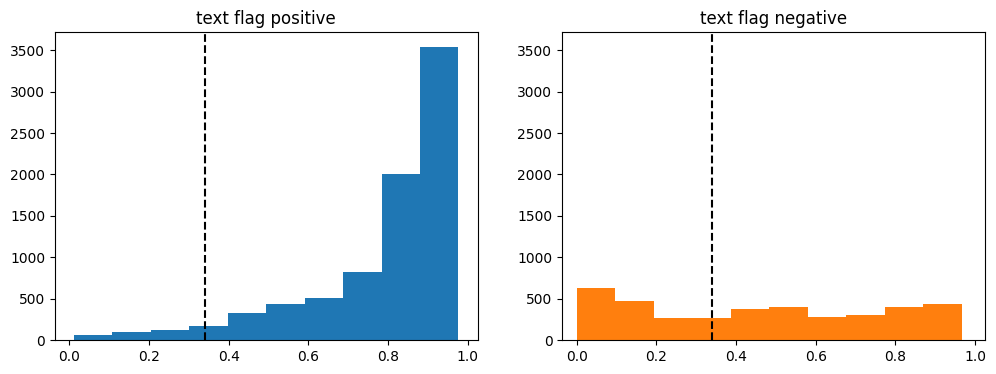

In [84]:
positivo = all_true_labels == 1
negativo = all_true_labels == 0

fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(all_logit_results[positivo], color = 'tab:blue');
axes[0].set_title('text flag positive');

axes[1].hist(all_logit_results[negativo], color = 'tab:orange');
axes[1].set_title('text flag negative');
axes[1].set_xlim(axes[0].get_xlim());
axes[1].set_ylim(axes[0].get_ylim());

[axes[i].axvline(x = best_thresholds, color = 'black', linestyle = 'dashed') for i in range(2)];

## val

In [85]:
all_binary_results, all_true_labels, all_logit_results = synthesis(runner, val_dl, best_thresholds)
metrics_table(all_binary_results, all_true_labels)

100%|██████████| 97/97 [01:15<00:00,  1.28it/s]


{'Accuracy': [0.7783534364122076, 0.7783534364122076],
 'F1 Score': [0.8542376490630323, 0.5376561972306653],
 'AUC ROC': [0.6789255749099539, 0.6789255749099539]}

In [86]:
confusion = np.zeros(shape = (2, 2))
N = len(all_binary_results)

for i in range(1 + 1):
    for j in range(1 + 1):
        confusion[i, j] = torch.sum((all_binary_results == i) * (all_true_labels == j))
confusion, N, np.round(confusion / N, decimals = 2)

(array([[1592.,  377.],
        [2361., 8023.]]),
 12353,
 array([[0.13, 0.03],
        [0.19, 0.65]]))

In [87]:
all_true_labels = all_true_labels.numpy().reshape(-1)
all_logit_results = all_logit_results.numpy().reshape(-1)

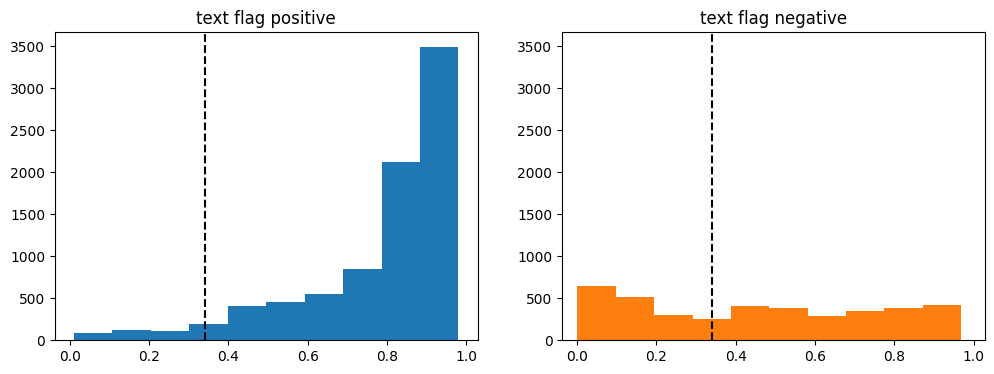

In [88]:
positivo = all_true_labels == 1
negativo = all_true_labels == 0

fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(all_logit_results[positivo], color = 'tab:blue');
axes[0].set_title('text flag positive');

axes[1].hist(all_logit_results[negativo], color = 'tab:orange');
axes[1].set_title('text flag negative');
axes[1].set_xlim(axes[0].get_xlim());
axes[1].set_ylim(axes[0].get_ylim());

[axes[i].axvline(x = best_thresholds, color = 'black', linestyle = 'dashed') for i in range(2)];